# Image generation

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Location Sampling

In [15]:
def get_noise_patch(noise_path: str, start_coords: tuple[int, int] = None, size: tuple[int, int] = (153, 206)):
    noise = cv2.imread(noise_path, cv2.IMREAD_GRAYSCALE)
    if noise is None:
        raise ValueError("Noise image could not be loaded.")

    h, w = noise.shape
    if start_coords is None:
        start_coords = (np.random.randint(0, h), np.random.randint(0, w))

    output = noise[start_coords[0]:start_coords[0] + size[0], start_coords[1]:start_coords[1] + size[1]]
    output -= np.min(output)
    output *= (255 // np.max(output))

    return output

In [16]:
def noise_based_sample(noise: np.ndarray, clustering: float = 2, num_samples: int = 1, max_jitter: float = 0.01):
    flat = noise.flatten().astype(np.float64).clip(30, 255) ** clustering
    flat = flat / flat.sum()
    samples = np.random.choice(a=flat.size, p=flat, size=num_samples, replace=True)
    samples = np.array([np.unravel_index(s, noise.shape) for s in samples], dtype=np.float64)
    samples[:, 0] /= noise.shape[0] - 1
    samples[:, 1] /= noise.shape[1] - 1

    if max_jitter is not None and max_jitter > 0:
        x_offsets = (np.random.random(num_samples) * max_jitter) - max_jitter / 2
        y_offsets = (np.random.random(num_samples) * max_jitter) - max_jitter / 2

        samples[:, 0] += y_offsets
        samples[:, 1] += x_offsets

    return samples.clip(0, 1), flat.reshape(noise.shape)

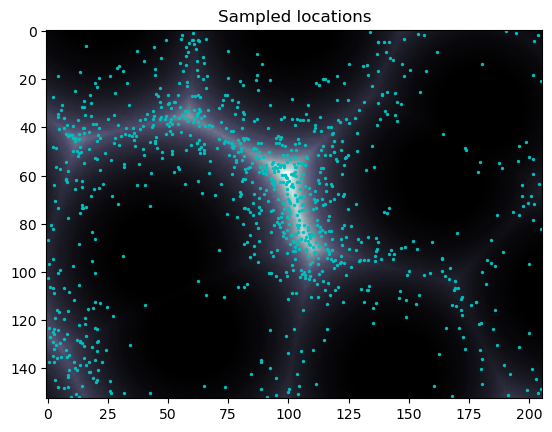

In [17]:
NOISE_IMAGE_PATH = "../data/images/noise/cellular-noise-1.png"

noise = get_noise_patch(NOISE_IMAGE_PATH, (300, 300))
samples, new_noise = noise_based_sample(noise, num_samples=1000, max_jitter=0.01, clustering=5)
samples[:, 0] *= noise.shape[0] - 1
samples[:, 1] *= noise.shape[1] - 1

plt.imshow(new_noise, cmap='bone', vmin=0)
plt.scatter([x for _, x in samples], [y for y, _ in samples], c='c', s=2)
plt.title("Sampled locations")
plt.show()

### Direction Sampling

In [18]:
def noise_based_sample_dir(noise: np.ndarray, clustering: float = 2, num_samples: int = 1,
                       max_jitter: float = 0.01, direction_sampling_window: int = 23):
    # Choose random indexes based on noise as probability distribution
    p = noise.astype(np.float64).clip(30, 255) ** clustering
    flat = p.flatten()
    flat = flat / flat.sum()
    samples = np.random.choice(a=flat.size, p=flat, size=num_samples, replace=True)
    samples = np.array([np.unravel_index(s, p.shape) for s in samples], dtype=np.float64)

    # Sampling starting directions from windows around each point
    directions = []

    half_win = direction_sampling_window // 2
    for y, x in samples:
        y, x = int(y), int(x)
        y0 = max(0, y - half_win)
        y1 = min(p.shape[0], y + half_win + 1)
        x0 = max(0, x - half_win)
        x1 = min(p.shape[1], x + half_win + 1)

        local_patch = p[y0:y1, x0:x1]
        local_flat = local_patch.flatten()
        local_flat = local_flat / local_flat.sum()

        grid_y, grid_x = np.meshgrid(
            np.linspace(-1, 1, local_patch.shape[0]),
            np.linspace(-1, 1, local_patch.shape[1]),
            indexing='ij'
        )
        local_angles = (np.degrees(np.arctan2(grid_y, grid_x)) + 360) % 360
        angle_choices = local_angles.flatten()

        sampled_angle = np.random.choice(angle_choices, p=local_flat)
        directions.append(int(sampled_angle))

    # Normalize to [0, 1] coordinate system
    samples[:, 0] /= p.shape[0] - 1
    samples[:, 1] /= p.shape[1] - 1

    if max_jitter is not None and max_jitter > 0:  # Randomly jitter locations
        x_offsets = (np.random.random(num_samples) * max_jitter) - max_jitter / 2
        y_offsets = (np.random.random(num_samples) * max_jitter) - max_jitter / 2

        samples[:, 0] += y_offsets
        samples[:, 1] += x_offsets

    return samples.clip(0, 1), directions, p

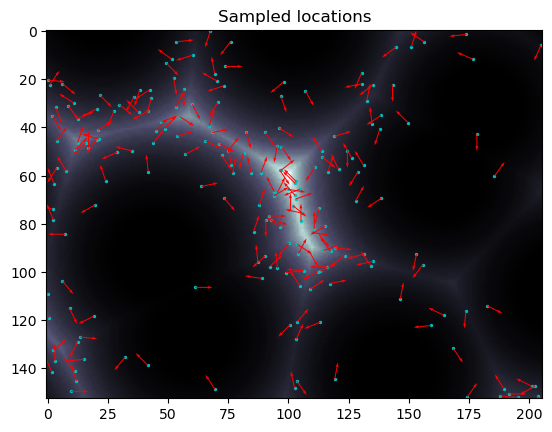

In [19]:
noise = get_noise_patch(NOISE_IMAGE_PATH, (300, 300))
samples, directions, new_noise = noise_based_sample_dir(noise, num_samples=200, max_jitter=0.01, clustering=5)
samples[:, 0] *= noise.shape[0] - 1
samples[:, 1] *= noise.shape[1] - 1

plt.imshow(new_noise, cmap='bone', vmin=0)
plt.scatter([x for _, x in samples], [y for y, _ in samples], c='c', s=2)
plt.quiver([x for _, x in samples], [y for y, _ in samples],
           [5 * np.cos(np.deg2rad(d)) for d in directions], [5 * np.sin(np.deg2rad(d)) for d in directions],
           angles='xy', scale_units='xy', scale=0.7, color='r', width=0.002)
plt.title("Sampled locations")
plt.show()

#### Gradient-Based Direction Sampling

In [20]:
def noise_based_sample_dir_grad(noise: np.ndarray, clustering: float = 2, num_samples: int = 1,
                                max_jitter: float = 0.01):
    # Choose random indexes based on noise as probability distribution
    p = noise.astype(np.float64).clip(30, 255) ** clustering
    flat = p.flatten()
    flat = flat / flat.sum()
    samples = np.random.choice(a=flat.size, p=flat, size=num_samples, replace=True)
    samples = np.array([np.unravel_index(s, p.shape) for s in samples], dtype=np.float64)

    # Sampling starting directions from windows around each point
    directions = []
    # Get gradient maps
    gy, gx = np.gradient(p)

    for y, x in samples:
        y, x = int(y), int(x)
        dx = gx[y, x]
        dy = gy[y, x]
        # Angle perpendicular to gradient
        angle = np.rad2deg(np.arctan2(dy, dx)) + (90 if np.random.random() < 0.5 else 270) % 360
        directions.append(int(angle))

    # Normalize to [0, 1] coordinate system
    samples[:, 0] /= p.shape[0] - 1
    samples[:, 1] /= p.shape[1] - 1

    if max_jitter is not None and max_jitter > 0:  # Randomly jitter locations
        x_offsets = (np.random.random(num_samples) * max_jitter) - max_jitter / 2
        y_offsets = (np.random.random(num_samples) * max_jitter) - max_jitter / 2

        samples[:, 0] += y_offsets
        samples[:, 1] += x_offsets

    return samples.clip(0, 1), directions, p

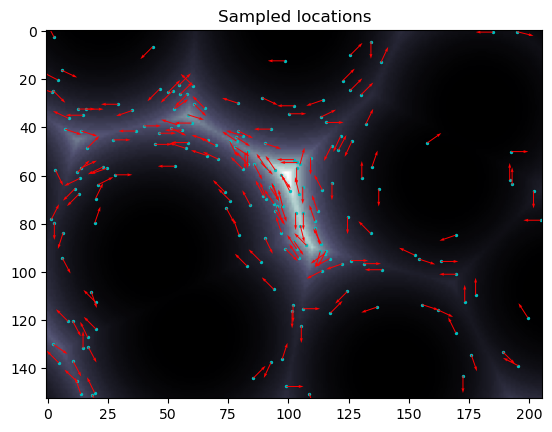

In [21]:
noise = get_noise_patch(NOISE_IMAGE_PATH, (300, 300))
samples, directions, new_noise = noise_based_sample_dir_grad(noise, num_samples=200, max_jitter=0.01, clustering=5)
samples[:, 0] *= noise.shape[0] - 1
samples[:, 1] *= noise.shape[1] - 1

plt.imshow(new_noise, cmap='bone', vmin=0)
plt.scatter([x for _, x in samples], [y for y, _ in samples], c='c', s=2)
plt.quiver([x for _, x in samples], [y for y, _ in samples],
           [5 * np.cos(np.deg2rad(d)) for d in directions], [5 * np.sin(np.deg2rad(d)) for d in directions],
           angles='xy', scale_units='xy', scale=0.7, color='r', width=0.002)
plt.title("Sampled locations")
plt.show()

#### Sampling direction based on both gradient and magnitude

In [22]:
def noise_based_sample_combined(noise: np.ndarray, clustering: float = 2, num_samples: int = 1,
                       max_jitter: float = 0.01, direction_sampling_window: int = 23):
    # Choose random indexes based on noise as probability distribution
    p = noise.astype(np.float64).clip(30, 255) ** clustering
    flat = p.flatten()
    flat = flat / flat.sum()
    samples = np.random.choice(a=flat.size, p=flat, size=num_samples, replace=True)
    samples = np.array([np.unravel_index(s, p.shape) for s in samples], dtype=np.float64)

    # Sampling starting directions from windows around each point
    directions = []
    gy, gx = np.gradient(noise)

    half_win = direction_sampling_window // 2
    for y, x in samples:
        y, x = int(y), int(x)
        y0 = max(0, y - half_win)
        y1 = min(p.shape[0], y + half_win + 1)
        x0 = max(0, x - half_win)
        x1 = min(p.shape[1], x + half_win + 1)

        local_patch = p[y0:y1, x0:x1]
        local_flat = local_patch.flatten()
        local_flat = local_flat / local_flat.sum()

        grid_y, grid_x = np.meshgrid(
            np.linspace(-1, 1, local_patch.shape[0]),
            np.linspace(-1, 1, local_patch.shape[1]),
            indexing='ij'
        )
        local_angles = np.arctan2(grid_y, grid_x)
        angle_choices = local_angles.flatten()

        sampled_angle = np.random.choice(angle_choices, p=local_flat)
        dx = gx[y, x]
        dy = gy[y, x]
        grad_angle = np.arctan2(dy, dx) + (0.5*np.pi if np.random.random() < 0.5 else 1.5*np.pi)
        
        # Create weighted average
        grad_strength = np.hypot(dx, dy)
        
        grad_weight = grad_strength / (grad_strength + 1)
        noise_weight = 1.0 - grad_weight
        
        x = grad_weight * np.cos(grad_angle) + noise_weight * np.cos(sampled_angle)
        y = grad_weight * np.sin(grad_angle) + noise_weight * np.sin(sampled_angle)
        final_angle = (np.rad2deg(np.arctan2(y, x)) + 360) % 360
        
        directions.append(int(final_angle))

    # Normalize to [0, 1] coordinate system
    samples[:, 0] /= p.shape[0] - 1
    samples[:, 1] /= p.shape[1] - 1

    if max_jitter is not None and max_jitter > 0:  # Randomly jitter locations
        x_offsets = (np.random.random(num_samples) * max_jitter) - max_jitter / 2
        y_offsets = (np.random.random(num_samples) * max_jitter) - max_jitter / 2

        samples[:, 0] += y_offsets
        samples[:, 1] += x_offsets

    return samples.clip(0, 1), directions, p

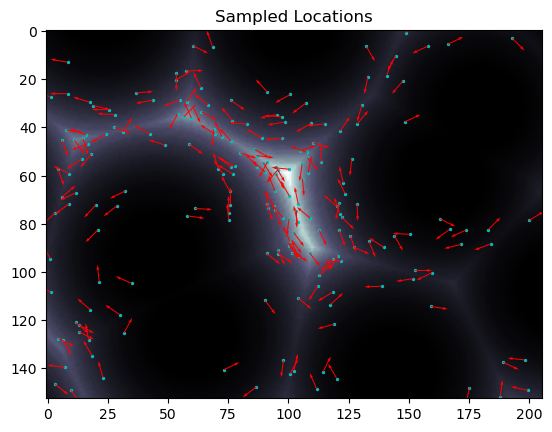

In [23]:
np.random.seed(0)
noise = get_noise_patch(NOISE_IMAGE_PATH, (300, 300))
samples, directions, new_noise = noise_based_sample_combined(noise, num_samples=200, max_jitter=0.01, clustering=5)
samples[:, 0] *= noise.shape[0] - 1
samples[:, 1] *= noise.shape[1] - 1

plt.imshow(new_noise, cmap='bone', vmin=0)
plt.scatter([x for _, x in samples], [y for y, _ in samples], c='c', s=2)
plt.quiver([x for _, x in samples], [y for y, _ in samples],
           [5 * np.cos(np.deg2rad(d)) for d in directions], [5 * np.sin(np.deg2rad(d)) for d in directions],
           angles='xy', scale_units='xy', scale=0.7, color='r', width=0.002)
plt.title("Sampled Locations")
plt.show()

# Generating a full image with these locations

In [24]:
import matplotlib.pyplot as plt
import cv2 as cv
from src.image_generator import get_fibre
from src.image_processing import add_noise

In [31]:
def generate_fiber_image(image_size: tuple[int, int] = (2472, 3296),
                         num_fibers: int = 60,
                         snr: float = 4.5, background_color: int = 135, fiber_color: int = None,
                         clustering: float = 2.0) -> np.ndarray:
    if fiber_color is None:
        fiber_color = background_color / 1.53

    # Create image of desired size with specified background color
    new_img = np.full(shape=image_size, dtype=np.uint8, fill_value=background_color)
    # PLOT BACKGROUND
    plt.imshow(new_img, cmap='grey', vmin=0, vmax=255)
    plt.imsave("figures/background.png", new_img, cmap='grey', vmin=0, vmax=255)
    plt.title("Background")
    plt.show()

    # Calculate noise strength
    # SNR = signal / noise -> noise = signal / SNR
    bg_sg_r = background_color / fiber_color
    signal = abs(fiber_color - background_color)
    noise_strength = signal / snr

    # Get fiber starting locations with noise sampling
    noise = get_noise_patch('../data/images/noise/cellular-noise-1.png')
    fiber_locs, dirs, new_noise = noise_based_sample_combined(noise=noise,
                                                   clustering=clustering,
                                                   num_samples=num_fibers,
                                                   max_jitter=0.05)
    fiber_locs = [(y * image_size[0], x * image_size[1]) for y, x in fiber_locs]
    # PLOT FIBRE DISTRIBUTION
    plt.imshow(cv.resize(new_noise, (3296, 2472), interpolation=cv.INTER_LINEAR), cmap='bone', vmin=0)
    plt.quiver([x for _, x in fiber_locs], [y for y, _ in fiber_locs],
               [100 * np.cos(np.deg2rad(d)) for d in dirs], [100 * np.sin(np.deg2rad(d)) for d in dirs],
               angles='xy', scale_units='xy', scale=0.5, color='r', width=0.004)
    plt.scatter([x for _, x in fiber_locs], [y for y, _ in fiber_locs], c='c', s=5)
    plt.xlim(0, 3296)
    plt.ylim(0, 2472)
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.savefig("figures/noise.png")
    plt.title("Sampled Locations")
    plt.show()

    for (start_y, start_x), start_direction in zip(fiber_locs, dirs):  # Make fibers

        # Generate fiber masks
        fiber_mask, inner_mask, _ = get_fibre(new_img, start_x, start_y, start_direction)

        # Apply fiber patterns to the image with color jittering so fibers are not all equal
        new_img[fiber_mask] = (new_img[fiber_mask] * (1 / max(1.1, bg_sg_r + 0.05 * np.random.random()))).astype(
            np.uint8)
        new_img[inner_mask] = (new_img[inner_mask] * (1.2 + 0.05 * np.random.random())).astype(np.uint8)
    
    plt.imshow(new_img, cmap='grey', vmin=0, vmax=255)
    plt.imsave("figures/fibers.png", new_img, cmap='grey', vmin=0, vmax=255)
    plt.title("Generated Fibres")
    plt.show()

    # Apply noise and blur
    new_img = add_noise(new_img, noise_strength=noise_strength)
    plt.imshow(new_img, cmap='grey', vmin=0, vmax=255)
    plt.imsave("figures/final.png", new_img, cmap='grey', vmin=0, vmax=255)
    plt.title("Final Image")
    plt.show()

    return new_img

### Image Generation Pipeline

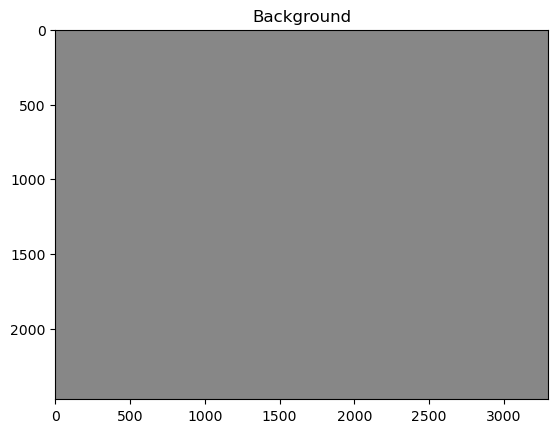

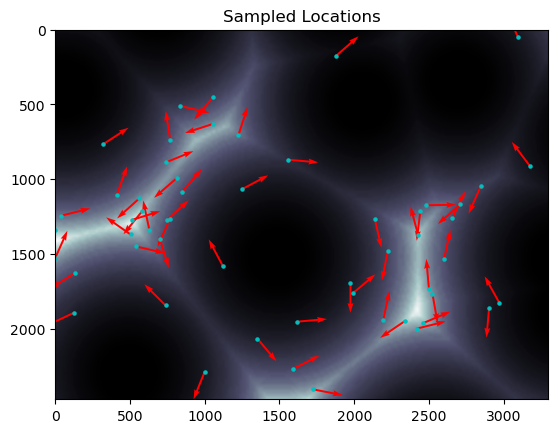

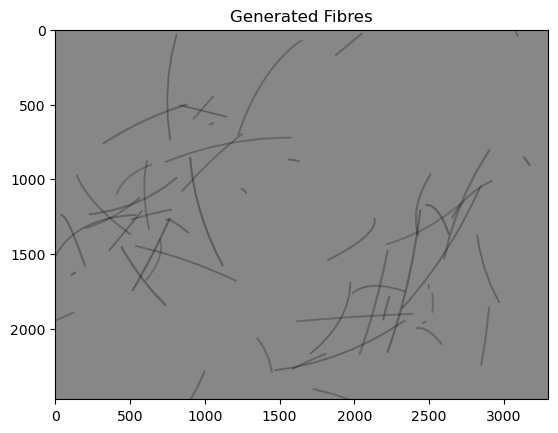

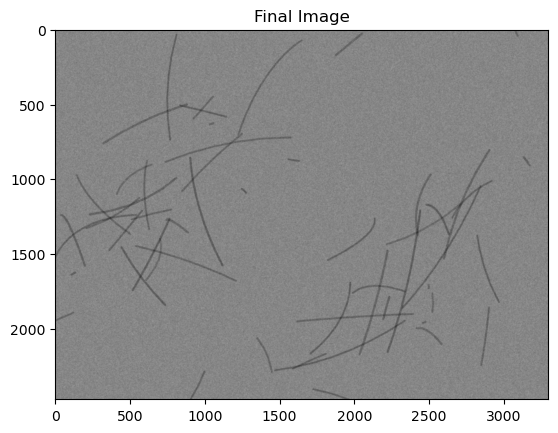

In [32]:
np.random.seed(123)
_ = generate_fiber_image(image_size=(2472, 3296),
                     num_fibers=55,
                     snr=4.5,
                     background_color=135,
                     fiber_color=None,
                     clustering=4.0)

# The End.